# Clerical Net
## Use Neural Network to Preprocess pdfs of Scanned Text

### Correcting Orientation is the Current Goal
TODO:
- [x] Download EMNIST
- [ ] Prepare training data using EMNIST Data to add random rotation and label with their angular offset
- [ ] Prepare pdf files 

### Create Label and Roation Data Loader

In [1]:
"""
Input: torchvision.dataset inputs, int batch_size
Output: Iterator of rotated images with their rotation as a label
"""
class rotation_loader(Iterator):
    
    def __init__(self, inputs, batch_size):
        self.inputs = inputs
        self.batch_size = batch_size
        self.pos = 0
        
    def __next__(self):
        angular_offset = random.randint(0, 360)
        
        

NameError: name 'Iterator' is not defined

### Retrieve EMNIST Data and Create Data Loaders

In [1]:
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF

batch_train = 30
batch_test = 30

train_loader = data.DataLoader(
    datasets.EMNIST('./emnist', split='balanced', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                    transforms.Normalize(mean=[0.5],std=[0.5]),
                                ])),
    batch_size=batch_train, shuffle=True)

test_loader = data.DataLoader(
    datasets.EMNIST('./emnist', split='balanced', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                ])),
    batch_size=batch_test, shuffle=True)

In [2]:
mapping_fp = r"./emnist/balanced_mapping.txt"
with open(mapping_fp, "rb") as f:
    mapping = {int(i): int(v) for line in f for i,v in [line.split()]}
_map = lambda x: (int(x) if x < 10 else chr(mapping[int(x)]))


In [3]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/usr/local/bin/miniconda3/envs/clerical_net/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [17]:
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8)
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1,28,28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1,28,28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [18]:
X_train.reshape(-1,28*28).shape

(60000, 784)

(<matplotlib.image.AxesImage at 0x7fe73cde72e0>, 5)

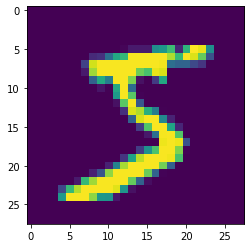

In [19]:
imshow(X_train[0]), Y_train[0]

### Create Labels and Rotate Images

torch.Size([30, 1, 28, 28])
torch.Size([1, 28, 28])


(<matplotlib.image.AxesImage at 0x7feaa42c2250>, 'R')

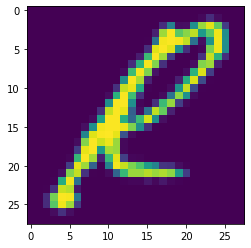

In [19]:
import random
import torch

def get_rot_mat(theta):
    theta = torch.tensor(float(theta))
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])

def rot_img(x, theta, dtype=torch.FloatTensor):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).type(dtype)
    x = F.grid_sample(x, grid)
    return x

image, _ = next(iter(train_loader))
print(image.shape)
print(image[0].shape)
imshow(image[0].permute(2,1,0)/255), _map(_[0])


### Create the Neural Net

In [22]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class clerical_net(nn.Module):
    
    def __init__(self):
        super(clerical_net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.fc1 = nn.Linear(128 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 360)
        
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 128 * 7 * 7)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return x

In [23]:
model = clerical_net()

In [ ]:
model()